In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

In [46]:
def read_and_preprocess(file_path, event_code, target_date_str):
    df = pd.read_csv(file_path, header=1)
    df['Created Date'] = pd.to_datetime(df['Created Date'], dayfirst=True)
    df['Event'] = event_code
    target_date = pd.to_datetime(target_date_str, dayfirst=True)
    df['T_minus'] = (target_date - df['Created Date']).dt.days
    return df

In [47]:
def combine_datasets(*datasets):
    return pd.concat(datasets, ignore_index=True)


In [48]:
def plot_registrations_countdown(combined_data,tile):
    t_minus_registrations = combined_data.groupby('T_minus').size()
    plt.figure(figsize=(20, 6))
    plt.plot(t_minus_registrations.index, t_minus_registrations.values, marker='o', linestyle='-', color='b')
    plt.title(tile)
    plt.xlabel('Days Until Event (T-minus)')
    plt.ylabel('Number of Registrations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [49]:
def calculate_daily_registrations(combined_data):
    daily_registrations = combined_data.groupby('Created Date').size().reset_index(name='Total Registrations')
    daily_registrations['Z-Score'] = (daily_registrations['Total Registrations'] - daily_registrations['Total Registrations'].mean()) / daily_registrations['Total Registrations'].std()
    daily_registrations['Advertisement'] = (daily_registrations['Z-Score'] > 1).astype(int)
    return daily_registrations

In [50]:
def prepare_for_forecasting(daily_registrations):
    first_date = daily_registrations['Created Date'].min()
    last_date = daily_registrations['Created Date'].max()
    date_range = pd.DataFrame(pd.date_range(start=first_date, end=last_date), columns=['Date'])
    complete_reg = pd.merge(date_range, daily_registrations, left_on='Date', right_on='Created Date', how='left', sort=True)
    complete_reg.drop(columns=['Created Date'], inplace=True)
    complete_reg['Total Registrations'].fillna(0, inplace=True)
    complete_reg['Z-Score'].fillna(0, inplace=True)
    complete_reg['Advertisement'].fillna(0, inplace=True)
    complete_reg['Date'] = pd.to_datetime(complete_reg['Date'])
    complete_reg = complete_reg.set_index('Date')
    return complete_reg


In [51]:
def split_data_for_forecasting(complete_reg, split_ratio=0.8):
    train_size = int(len(complete_reg) * split_ratio)
    train = complete_reg.iloc[:train_size]
    test = complete_reg.iloc[train_size:]

    train_endog = train['Total Registrations']
    train_exog = train[['Advertisement']]
    test_endog = test['Total Registrations']
    test_exog = test[['Advertisement']]

    return train_endog, train_exog, test_endog, test_exog

def auto_arima_forecasting(endog, exog):
    auto_model = auto_arima(endog, exogenous=exog, seasonal=True, m=7, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
    print(auto_model.summary())
    return auto_model.order, auto_model.seasonal_order

def sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order):
    model = SARIMAX(train_endog, order=order, seasonal_order=seasonal_order, exog=train_exog)
    results = model.fit()
    print(results.summary())
    forecast_results = results.get_forecast(steps=len(test_exog), exog=test_exog)
    return forecast_results.predicted_mean, forecast_results.conf_int()


In [52]:
def plot_forecast_vs_actuals(train, test, forecast_values, conf_int):
    
    # Plotting
    plt.figure(figsize=(30, 6))

    # Plot the observed values
    plt.plot(train.index, train['Total Registrations'], label='Train', color='blue')
    plt.plot(test.index, test['Total Registrations'], label='Test', color='green')

    # Plot the forecasted values
    plt.plot(test.index, forecast_values, label='Forecast', color='red')

    # Plot the confidence interval
    plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Total Registrations')
    plt.title('SARIMAX Model Forecast vs Actuals')
    plt.legend()
    plt.show()


In [53]:
# Using ARIMA

# Function to split the dataset into training and testing sets
def split_time_series_data(data, split_ratio=0.8):
    split_index = int(len(data) * split_ratio)
    train = data.iloc[:split_index]
    test = data.iloc[split_index:]
    return train, test

# Function to find the best ARIMA model order
def find_best_arima_order(endog):
    auto_model = auto_arima(endog, seasonal=False, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True, start_p=1, start_q=1, max_p=5, max_q=5, d=None, test='adf', start_P=0, D=0)
    print("Best ARIMA order:", auto_model.order)
    return auto_model.order

# Function to forecast using ARIMA
def arima_forecasting(endog, order):
    model = ARIMA(endog, order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    
    forecast_results = fitted_model.get_forecast(steps=len(test_endog_ar))
    forecast_values_arima = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()
    return forecast_values_arima, conf_int

In [54]:
# Using Exponential Smoothing
def exp_smoothing(endog, seasonal_periods = 7):
    model = ExponentialSmoothing(endog, trend = 'add', seasonal = 'add', seasonal_periods = seasonal_periods)
    fitted = model.fit()
    forecast_values_exp = fitted.forecast(steps = len(test_endog_exp))
    return forecast_values_exp

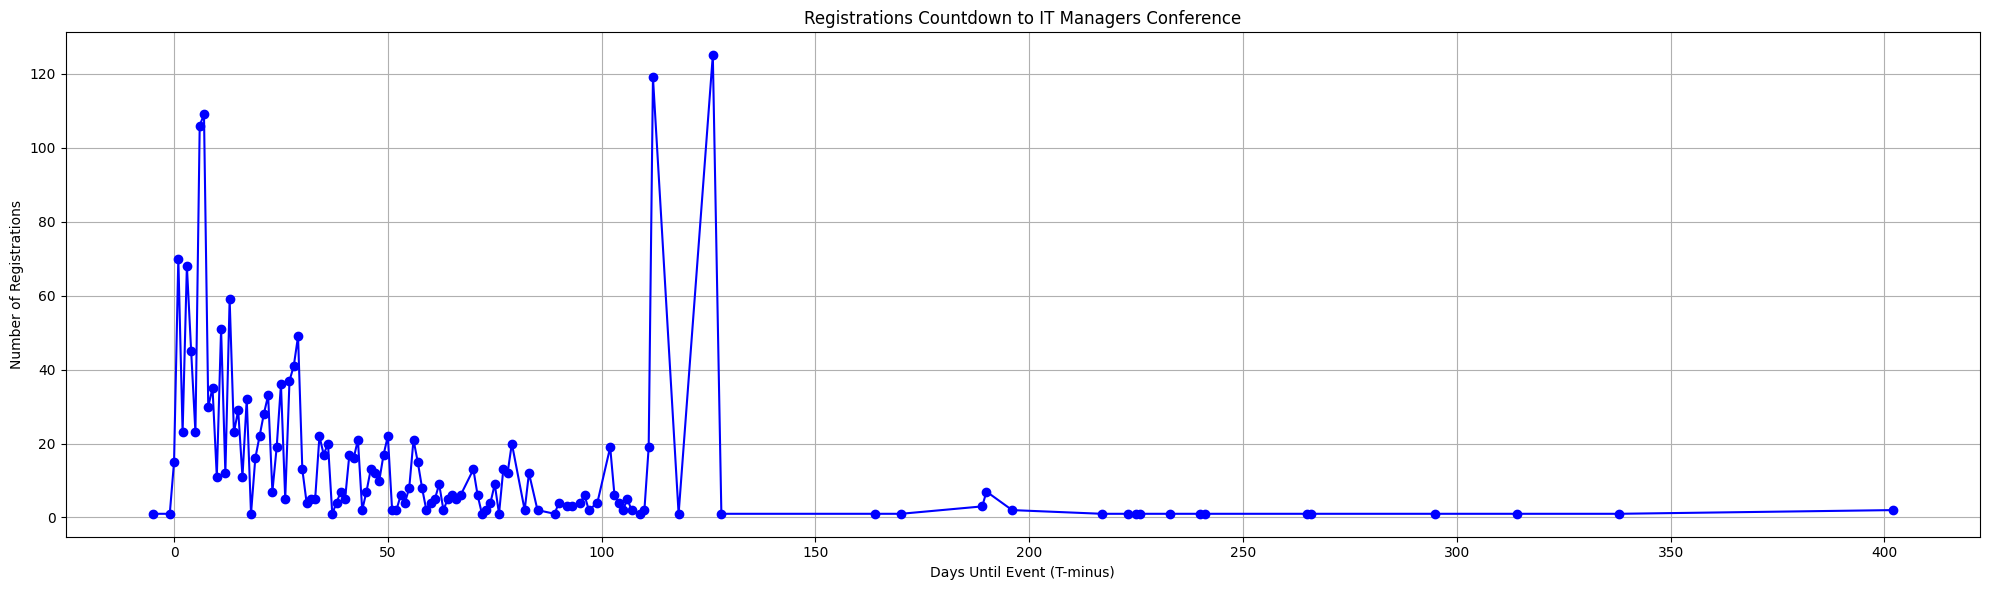

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5241.894, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5144.259, Time=0.80 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5036.145, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5240.118, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5035.345, Time=0.22 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=5035.091, Time=0.41 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4932.088, Time=0.91 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=4930.687, Time=1.11 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4992.586, Time=1.26 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=4932.664, Time=1.75 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4940.429, Time=1.38 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=5155.032, Time=1.13 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=i

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                Total Registrations   No. Observations:                  706
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1989.003
Date:                            Tue, 20 Feb 2024   AIC                           3990.007
Time:                                    18:42:57   BIC                           4017.356
Sample:                                07-16-2019   HQIC                          4000.575
                                     - 06-20-2021                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    58.8809      0.341    172.564      0.000      58.212      59.550
ar.L1             0.2237  

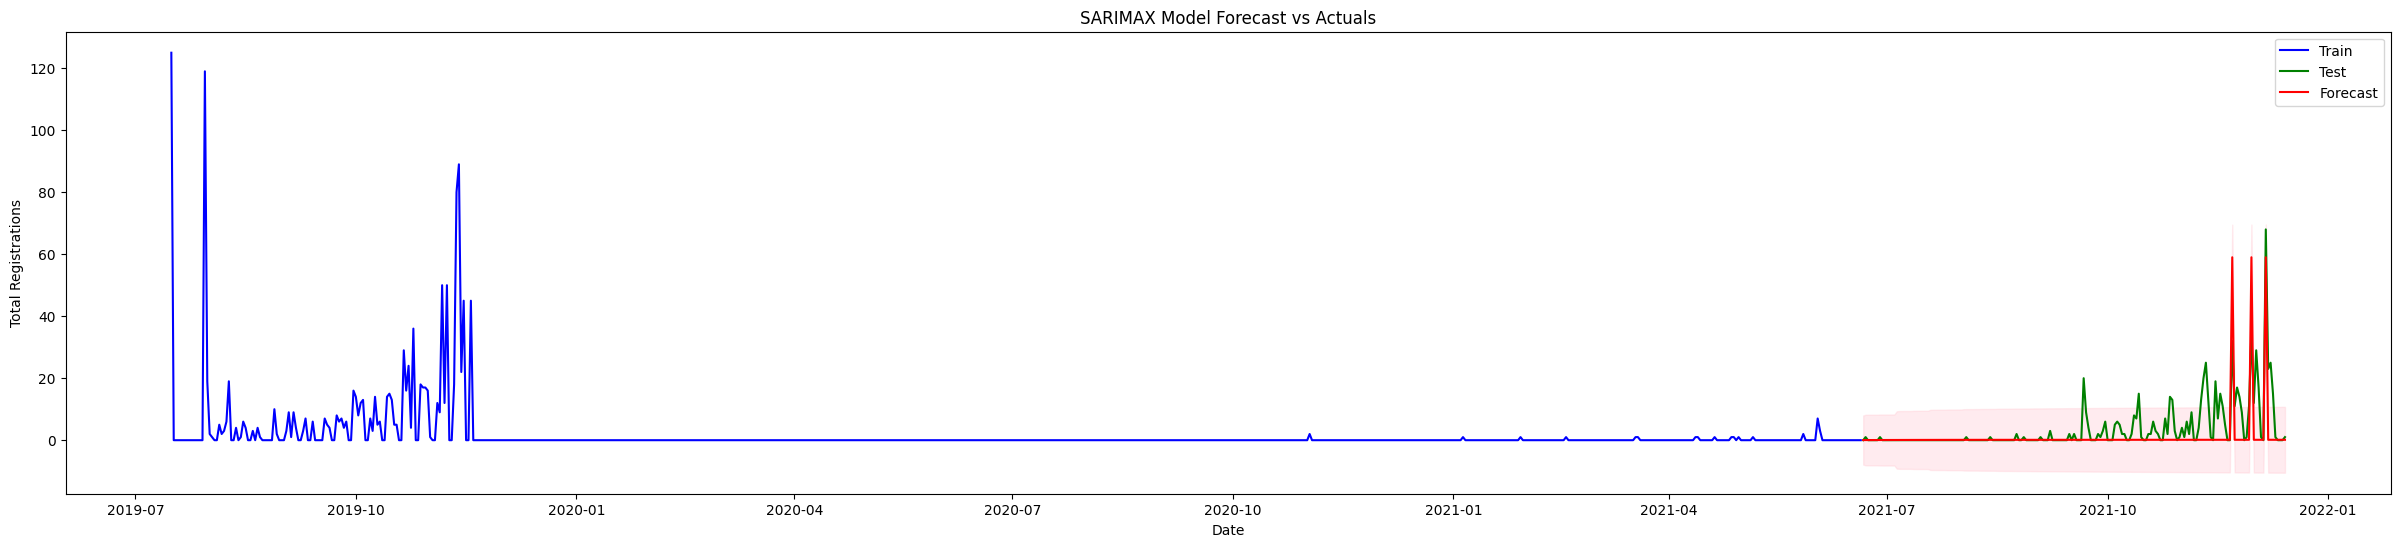

In [55]:
# IT Managers SARIMAX

# D19 & D21
d19 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D19.csv", 'D19', '19/11/2019')
d21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D21.csv", 'D21', '09/12/2021')

# Combine datasets
combined_it_managers = combine_datasets(d19, d21)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_it_managers, 'Registrations Countdown to IT Managers Conference')
daily_registrations_it = calculate_daily_registrations(combined_it_managers)
complete_reg_it = prepare_for_forecasting(daily_registrations_it)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_it)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_it.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5036.498, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5164.094, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5067.886, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5096.164, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5023.965, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5056.382, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5025.764, Time=0.45 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5025.849, Time=0.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5025.434, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=5056.092, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5021.027, Time=0.72 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=5022.843, Time=1.05 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=5029.673, Time=1.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5021.277, Time=0.68 sec
 ARIMA(4,0,1)(0,0,0)[0]          

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregre

                                SARIMAX Results                                
Dep. Variable:     Total Registrations   No. Observations:                  706
Model:                  ARIMA(4, 0, 3)   Log Likelihood               -2496.545
Date:                 Tue, 20 Feb 2024   AIC                           5011.089
Time:                         18:43:22   BIC                           5052.126
Sample:                     07-16-2019   HQIC                          5026.946
                          - 06-20-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8696     11.078      0.169      0.866     -19.843      23.582
ar.L1         -0.5262      0.035    -14.845      0.000      -0.596      -0.457
ar.L2          1.0311      0.017     61.300 

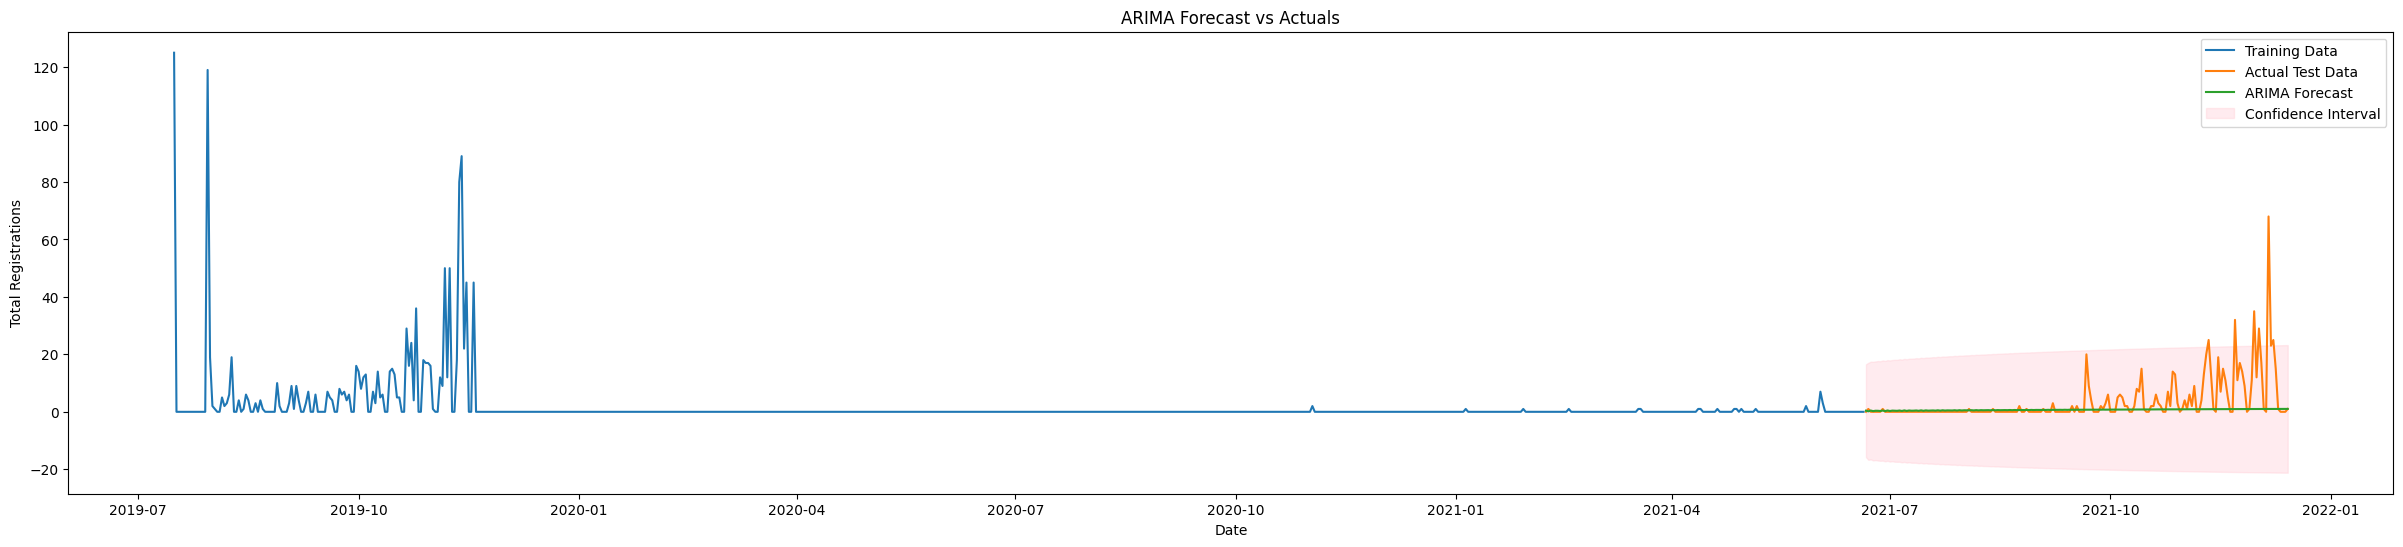

In [56]:
# IT Managers ARIMA 
train, test = split_time_series_data(complete_reg_it, split_ratio=0.8)

# For ARIMA, focusing on the endogenous variable only
train_endog_ar = train['Total Registrations']
test_endog_ar = test['Total Registrations']

# Finding the best ARIMA order
order = find_best_arima_order(train_endog_ar)

# Forecasting with ARIMA
forecast_values_arima, conf_int = arima_forecasting(train_endog_ar, order)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_ar, label='Training Data')
plt.plot(test.index, test_endog_ar, label='Actual Test Data')
plt.plot(test.index, forecast_values_arima, label='ARIMA Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


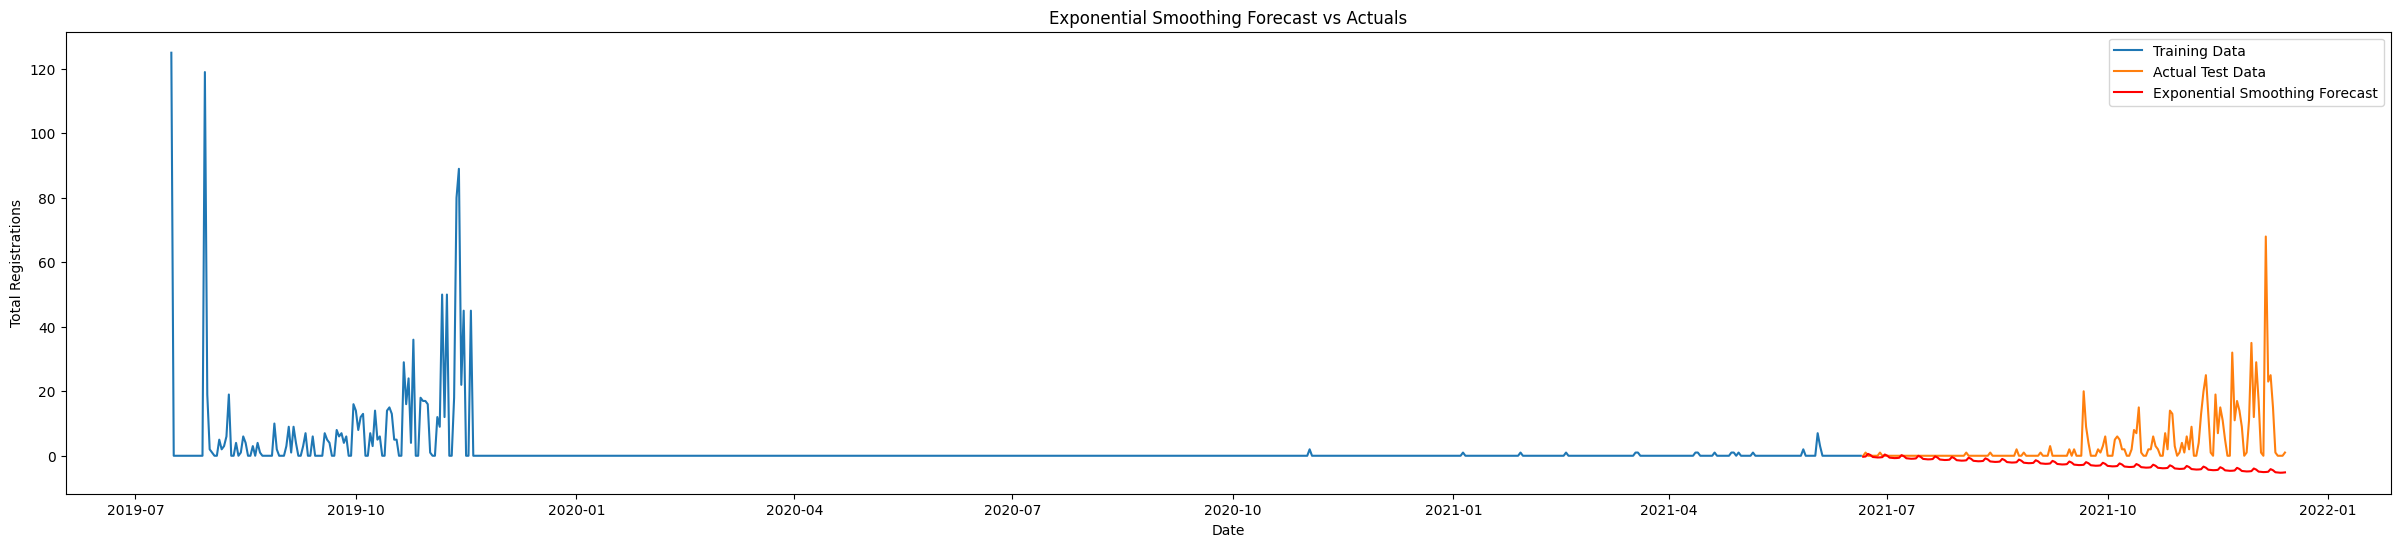

In [57]:
# IT Managers EXP
train, test = split_time_series_data(complete_reg_it, split_ratio=0.8)

train_endog_exp= train['Total Registrations']
test_endog_exp = test['Total Registrations']

forecast_values_exp = exp_smoothing(train_endog_exp)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_exp, label='Training Data')
plt.plot(test.index, test_endog_exp, label='Actual Test Data')
plt.plot(test.index, forecast_values_exp, label='Exponential Smoothing Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.show()

In [58]:
# Calculate RMSE and MAE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_endog_ar, forecast_values_arima))
mae_arima = mean_absolute_error(test_endog_ar, forecast_values_arima)

# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

#Calculate RMSE and MAE for Exponential Smoothing
rmse_exp = np.sqrt(mean_squared_error(test_endog_exp, forecast_values_exp))
mae_exp = mean_squared_error(test_endog_exp, forecast_values_exp)

# Print the results
print(f"ARIMA RMSE (IT): {rmse_arima:.2f}, MAE: {mae_arima:.2f}")
print(f"SARIMAX RMSE (IT): {rmse_sarimax:.2f}, MAE: {mae_sarimax:.2f}")
print(f"Exponential Smoothing RMSE (IT): {rmse_exp:.2f}, MAE: {mae_exp:.2f}")

ARIMA RMSE (IT): 8.59, MAE: 3.66
SARIMAX RMSE (IT): 6.94, MAE: 3.24
Exponential Smoothing RMSE (IT): 10.85, MAE: 117.67


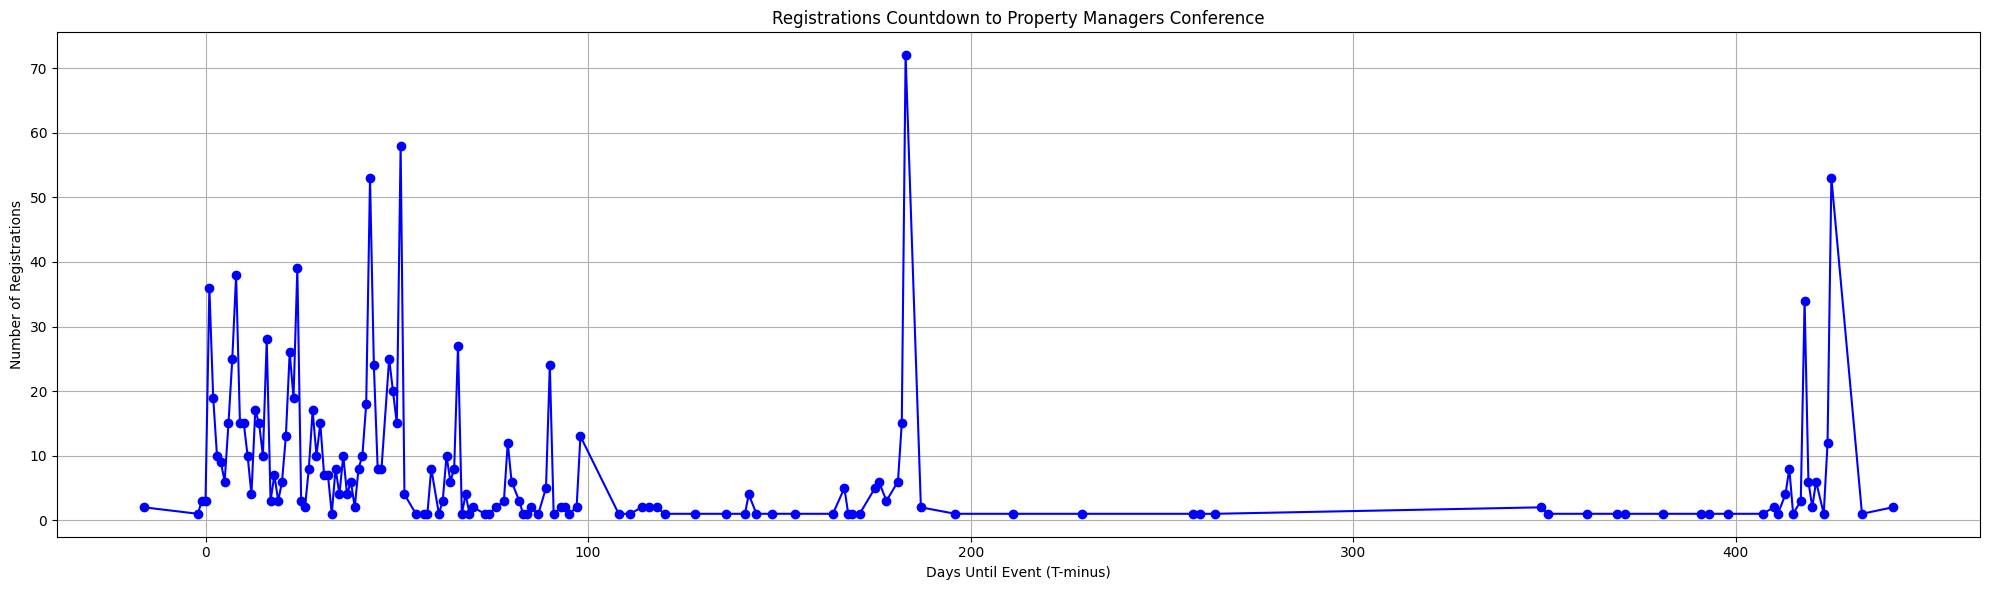

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3393.565, Time=2.96 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3624.490, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3532.355, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3412.645, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3622.490, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=3395.634, Time=1.74 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=3394.503, Time=1.36 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=3393.639, Time=3.15 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=3393.219, Time=4.11 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=3397.176, Time=2.71 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=3391.950, Time=4.74 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=3390.075, Time=4.39 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=3391.518, Time=4.13 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=3391.873, Time=3.62 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                    Total Registrations   No. Observations:                  527
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1397.051
Date:                                Tue, 20 Feb 2024   AIC                           2810.102
Time:                                        18:44:49   BIC                           2844.224
Sample:                                    02-06-2020   HQIC                          2823.462
                                         - 07-16-2021                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    31.4070      0.329     95.366      0.000      30.762      3

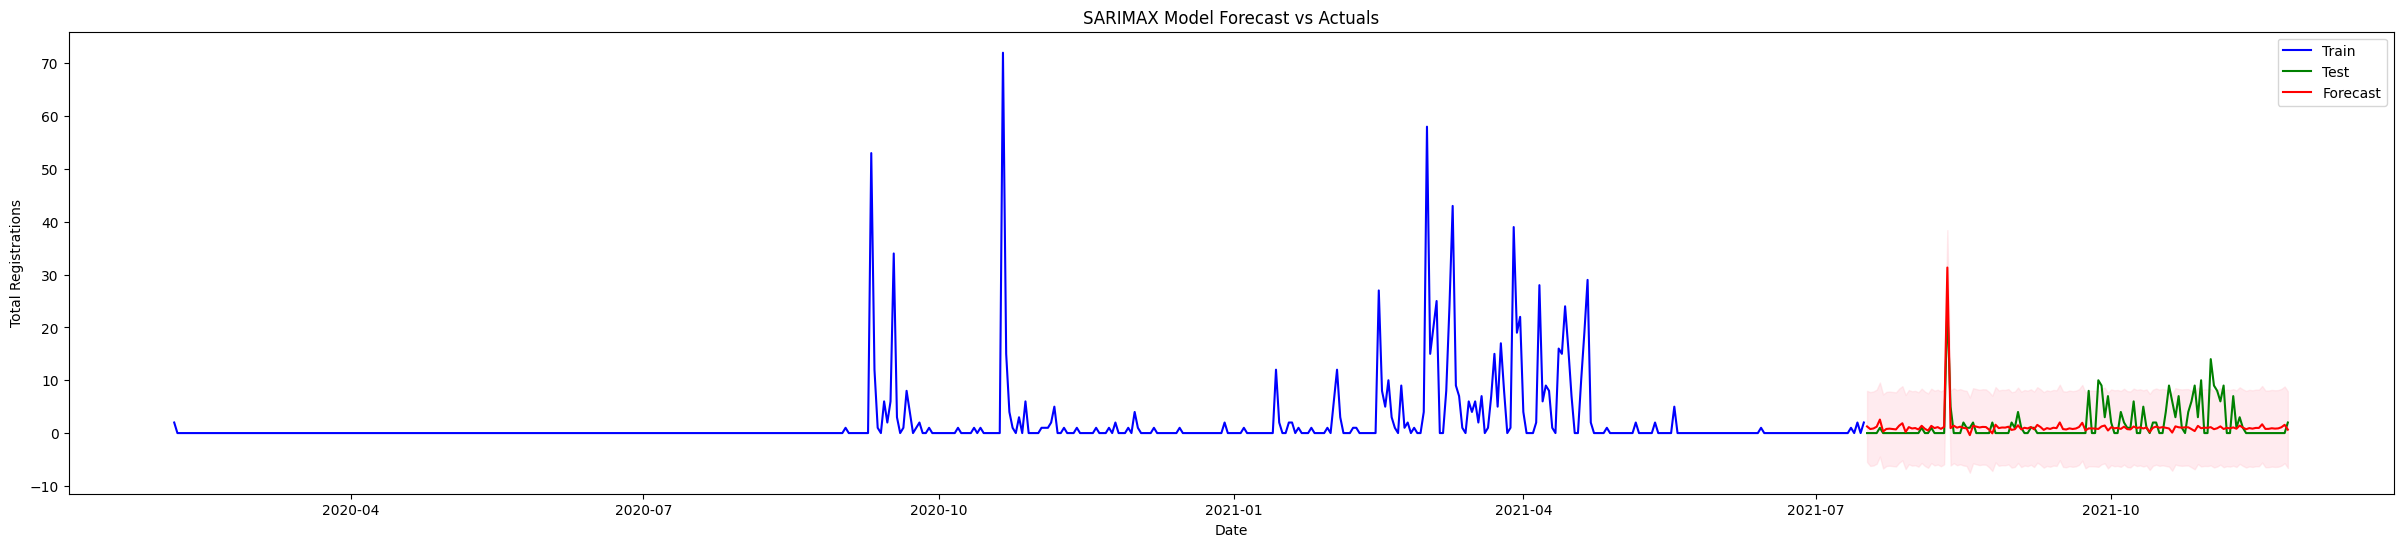

In [59]:
# Property Managers SARIMAX:
# GP21 and NP21
gp21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\GP21.csv", 'GP21', '22/04/2021')
np21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\NP21.csv", 'NP21', '09/11/2021')

# Combine datasets 
combined_property_managers = combine_datasets(gp21, np21)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_property_managers, 'Registrations Countdown to Property Managers Conference')
daily_registrations_prop = calculate_daily_registrations(combined_property_managers)
complete_reg_prop = prepare_for_forecasting(daily_registrations_prop)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_prop)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_prop.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3428.738, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3537.767, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3444.963, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3466.084, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3408.214, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3442.300, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3409.562, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3409.795, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3408.253, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3442.216, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3408.642, Time=0.48 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 3.232 seconds
Best ARIMA order: (2, 0, 1)


c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     Total Registrations   No. Observations:                  527
Model:                  ARIMA(2, 0, 1)   Log Likelihood               -1699.321
Date:                 Tue, 20 Feb 2024   AIC                           3408.642
Time:                         18:44:53   BIC                           3429.978
Sample:                     02-06-2020   HQIC                          3416.995
                          - 07-16-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6692      4.226      0.395      0.693      -6.614       9.952
ar.L1          1.2051      0.063     19.268      0.000       1.083       1.328
ar.L2         -0.2228      0.055     -4.025 

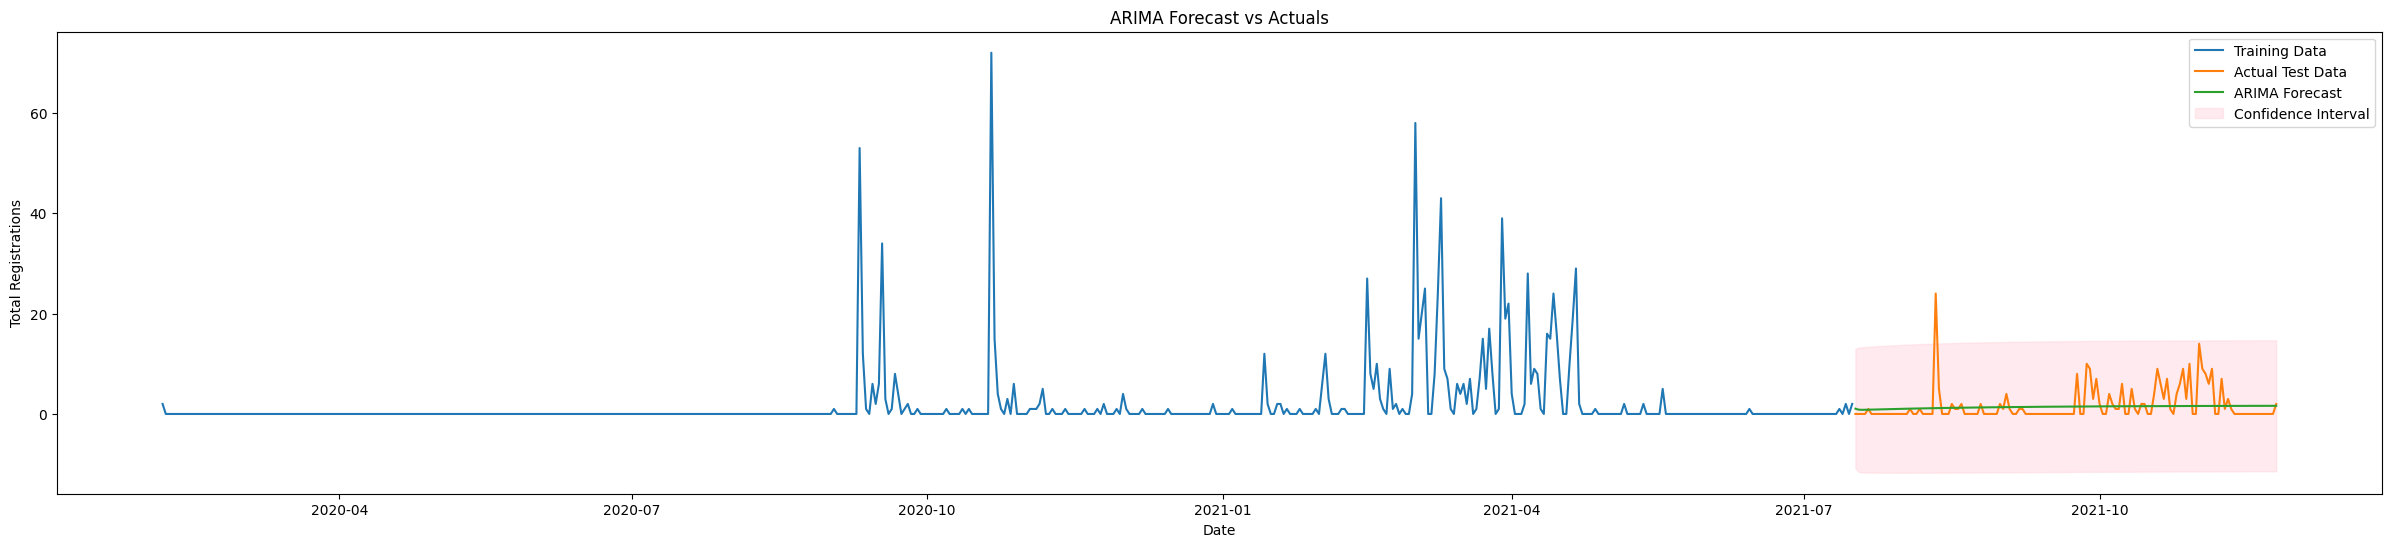

In [60]:
# Property Managers ARIMA
train, test = split_time_series_data(complete_reg_prop, split_ratio=0.8)

# For ARIMA, focusing on the endogenous variable only
train_endog_ar = train['Total Registrations']
test_endog_ar = test['Total Registrations']

# Finding the best ARIMA order
order = find_best_arima_order(train_endog_ar)

# Forecasting with ARIMA
forecast_values_arima, conf_int = arima_forecasting(train_endog_ar, order)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_ar, label='Training Data')
plt.plot(test.index, test_endog_ar, label='Actual Test Data')
plt.plot(test.index, forecast_values_arima, label='ARIMA Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


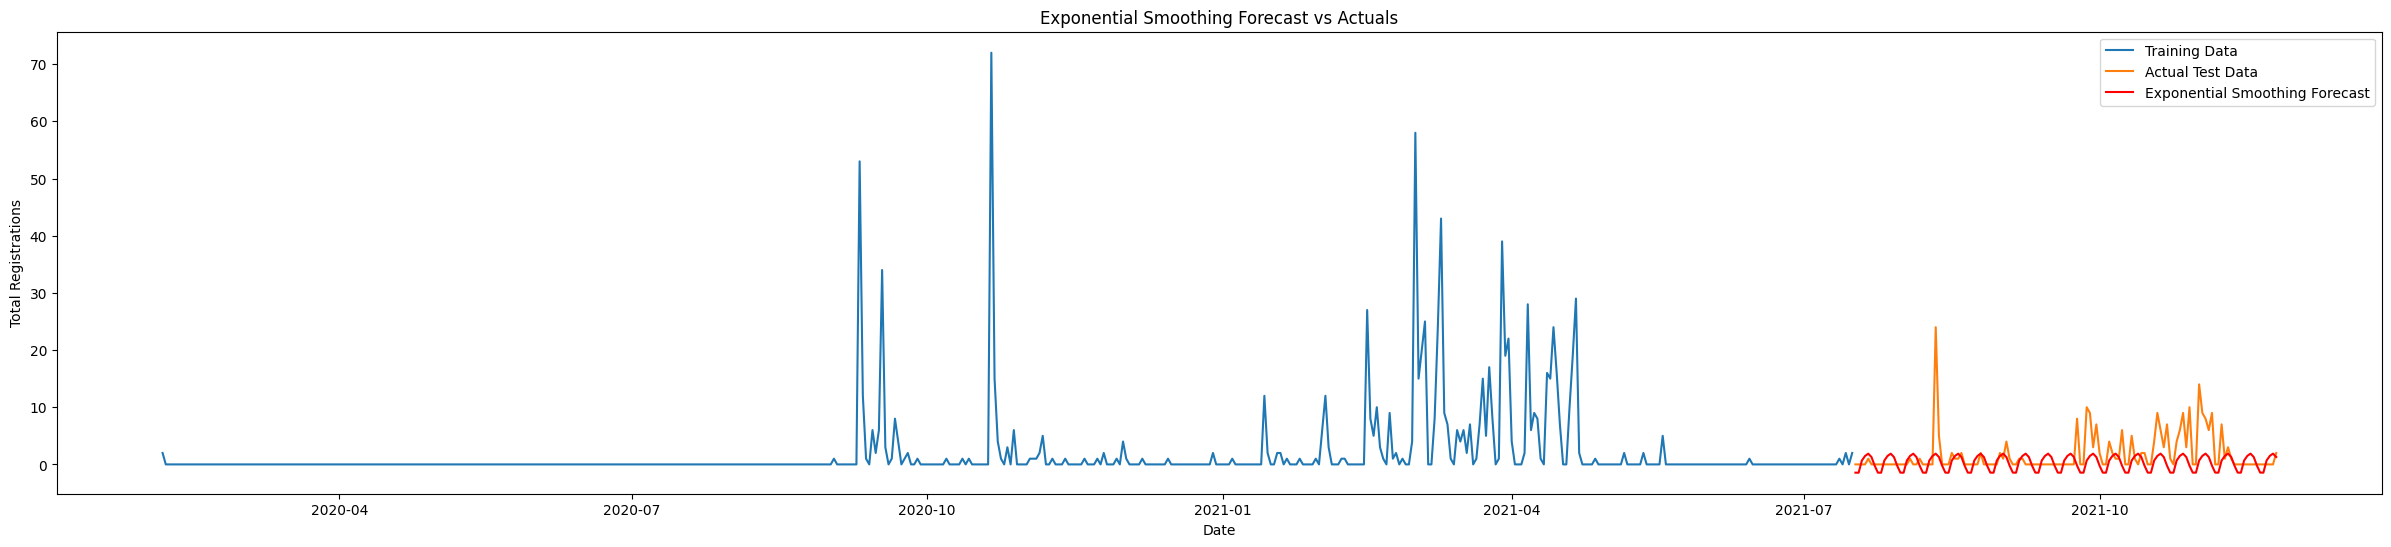

In [61]:
# Property Managers EXP
train, test = split_time_series_data(complete_reg_prop, split_ratio=0.8)

train_endog_exp= train['Total Registrations']
test_endog_exp = test['Total Registrations']

forecast_values_exp = exp_smoothing(train_endog_exp)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_exp, label='Training Data')
plt.plot(test.index, test_endog_exp, label='Actual Test Data')
plt.plot(test.index, forecast_values_exp, label='Exponential Smoothing Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.show()

In [62]:
# Calculate RMSE and MAE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_endog_ar, forecast_values_arima))
mae_arima = mean_absolute_error(test_endog_ar, forecast_values_arima)

# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

#Calculate RMSE and MAE for Exponential Smoothing
rmse_exp = np.sqrt(mean_squared_error(test_endog_exp, forecast_values_exp))
mae_exp = mean_squared_error(test_endog_exp, forecast_values_exp)

# Print the results
print(f"ARIMA RMSE (Property): {rmse_arima:.2f}, MAE: {mae_arima:.2f}")
print(f"SARIMAX RMSE (Property): {rmse_sarimax:.2f}, MAE: {mae_sarimax:.2f}")
print(f"Exponential Smoothing RMSE (Property): {rmse_exp:.2f}, MAE: {mae_exp:.2f}")

ARIMA RMSE (Property): 3.44, MAE: 2.10
SARIMAX RMSE (Property): 3.05, MAE: 1.92
Exponential Smoothing RMSE (Property): 3.63, MAE: 13.19


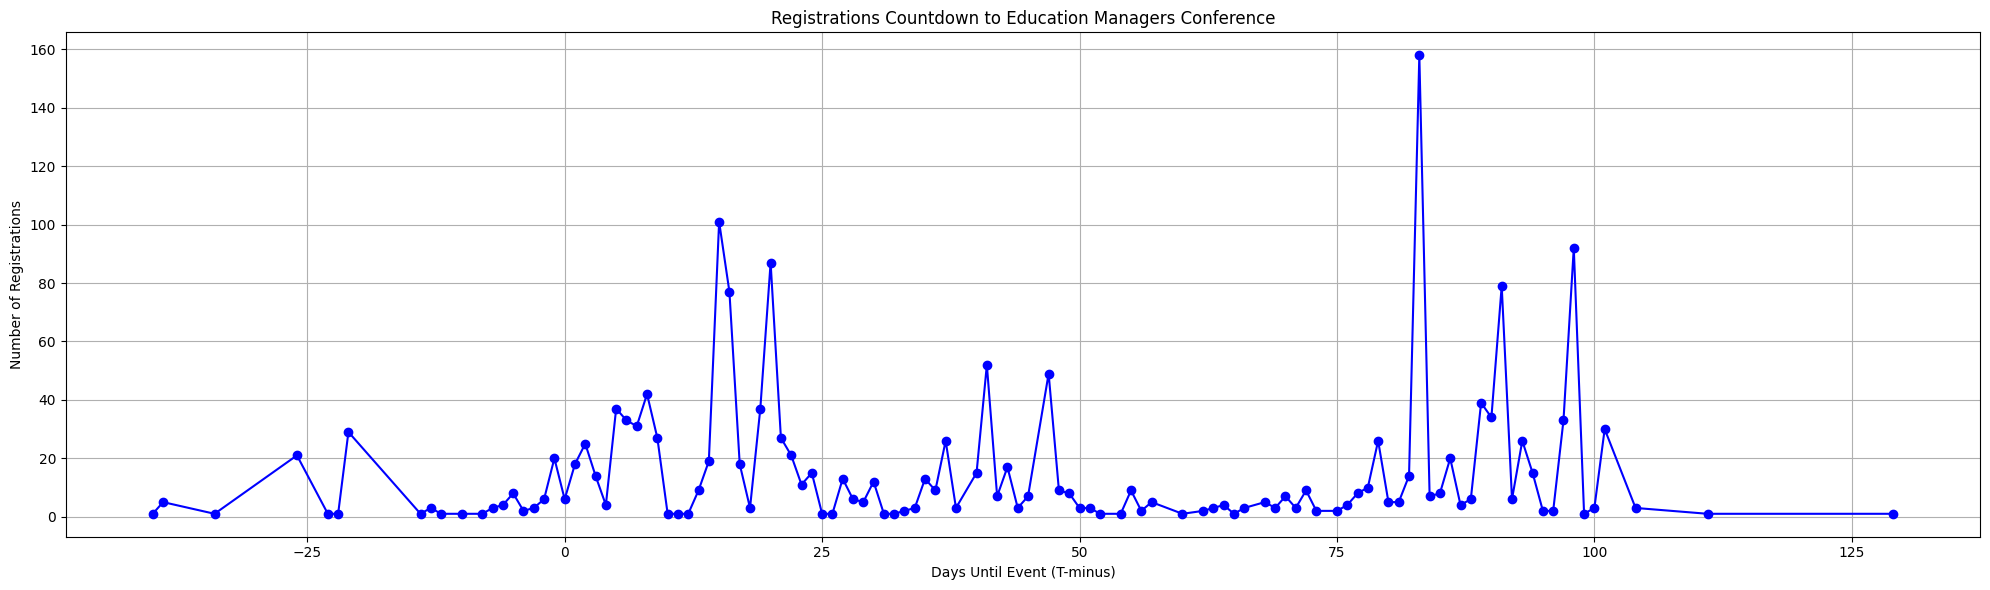

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3034.471, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3219.312, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3155.254, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3033.884, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3217.369, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3031.898, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3033.884, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3028.142, Time=1.21 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3027.241, Time=1.74 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3035.883, Time=0.56 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3022.385, Time=3.61 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3026.483, Time=1.95 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=3032.138, Time=2.81 sec
 ARIMA(0,1,2)(2,0,2)[7] intercept   : 

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                    Total Registrations   No. Observations:                  392
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1326.476
Date:                                Tue, 20 Feb 2024   AIC                           2666.952
Time:                                        18:45:28   BIC                           2694.733
Sample:                                    03-16-2022   HQIC                          2677.963
                                         - 04-11-2023                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    50.6749      0.839     60.370      0.000      49.030      5

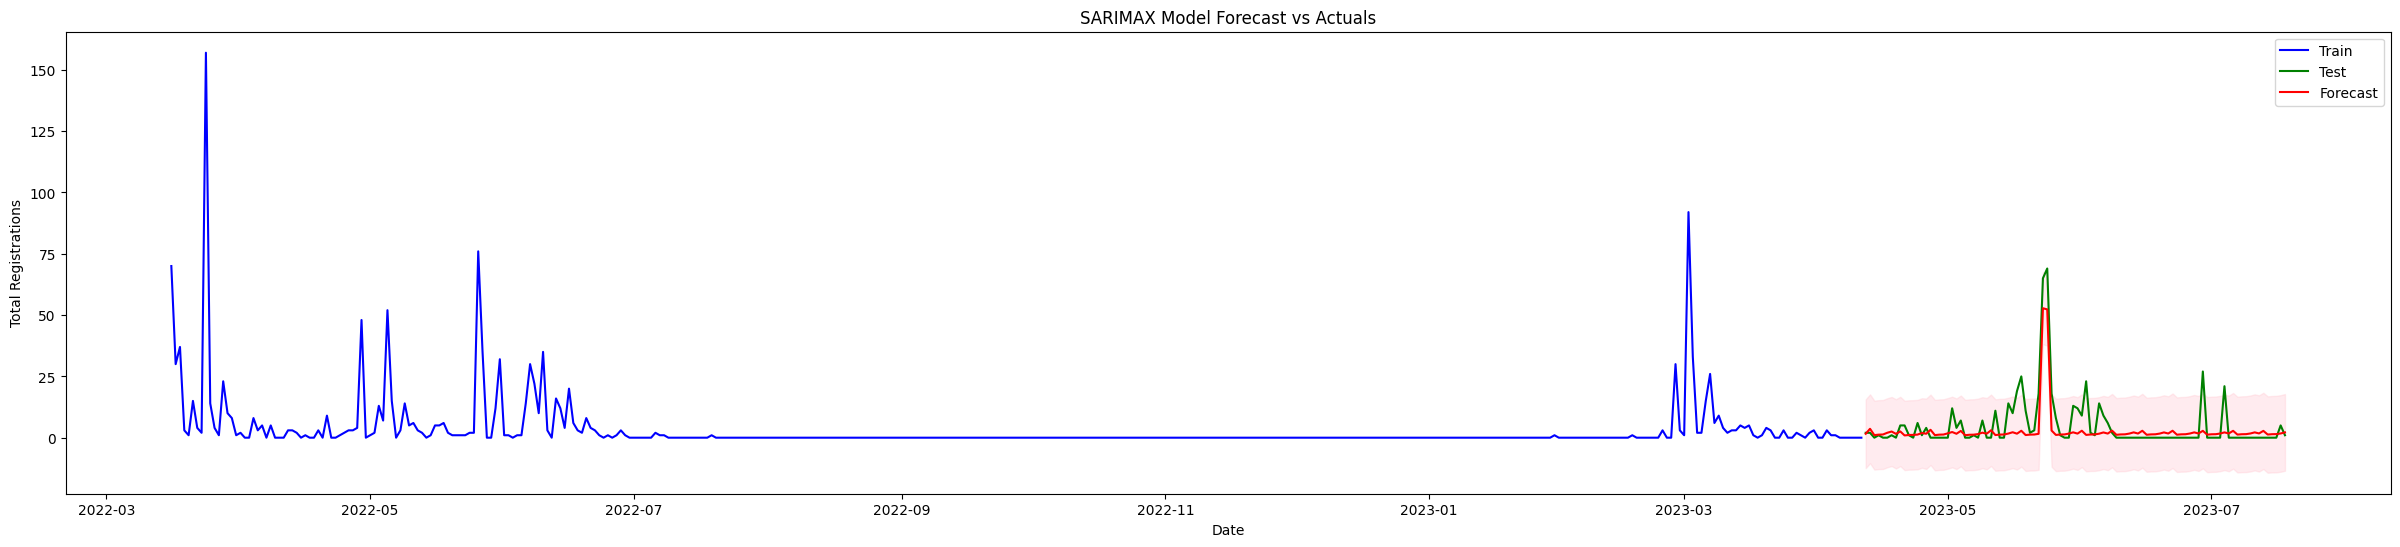

In [63]:
# Education Managers SARIMAX
# SRM22 and SRM23
srm22 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM22.csv", 'SRM22', '15/06/2022')
srm23 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM23.csv", 'SRM23', '08/06/2023')

# Combine datasets
combined_ed_managers = combine_datasets(srm22, srm23)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_ed_managers, 'Registrations Countdown to Education Managers Conference')
daily_registrations_ed = calculate_daily_registrations(combined_ed_managers)
complete_reg_ed = prepare_for_forecasting(daily_registrations_ed)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_ed)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_ed.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3039.079, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3104.584, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3071.346, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3076.563, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3039.058, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3070.922, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3036.339, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3062.330, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3037.999, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3037.355, Time=0.55 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3039.115, Time=0.57 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3055.314, Time=0.16 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=3034.214, Time=0.65 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=3036.191, Time=1.07 sec
 ARIMA(4,0,3)(0,0,0)[0]          

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     Total Registrations   No. Observations:                  392
Model:                  ARIMA(3, 0, 3)   Log Likelihood               -1511.331
Date:                 Tue, 20 Feb 2024   AIC                           3038.663
Time:                         18:45:41   BIC                           3070.433
Sample:                     03-16-2022   HQIC                          3051.254
                          - 04-11-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3355      4.409      1.210      0.226      -3.306      13.977
ar.L1          1.4886      0.304      4.897      0.000       0.893       2.084
ar.L2         -0.5919      0.400     -1.479 

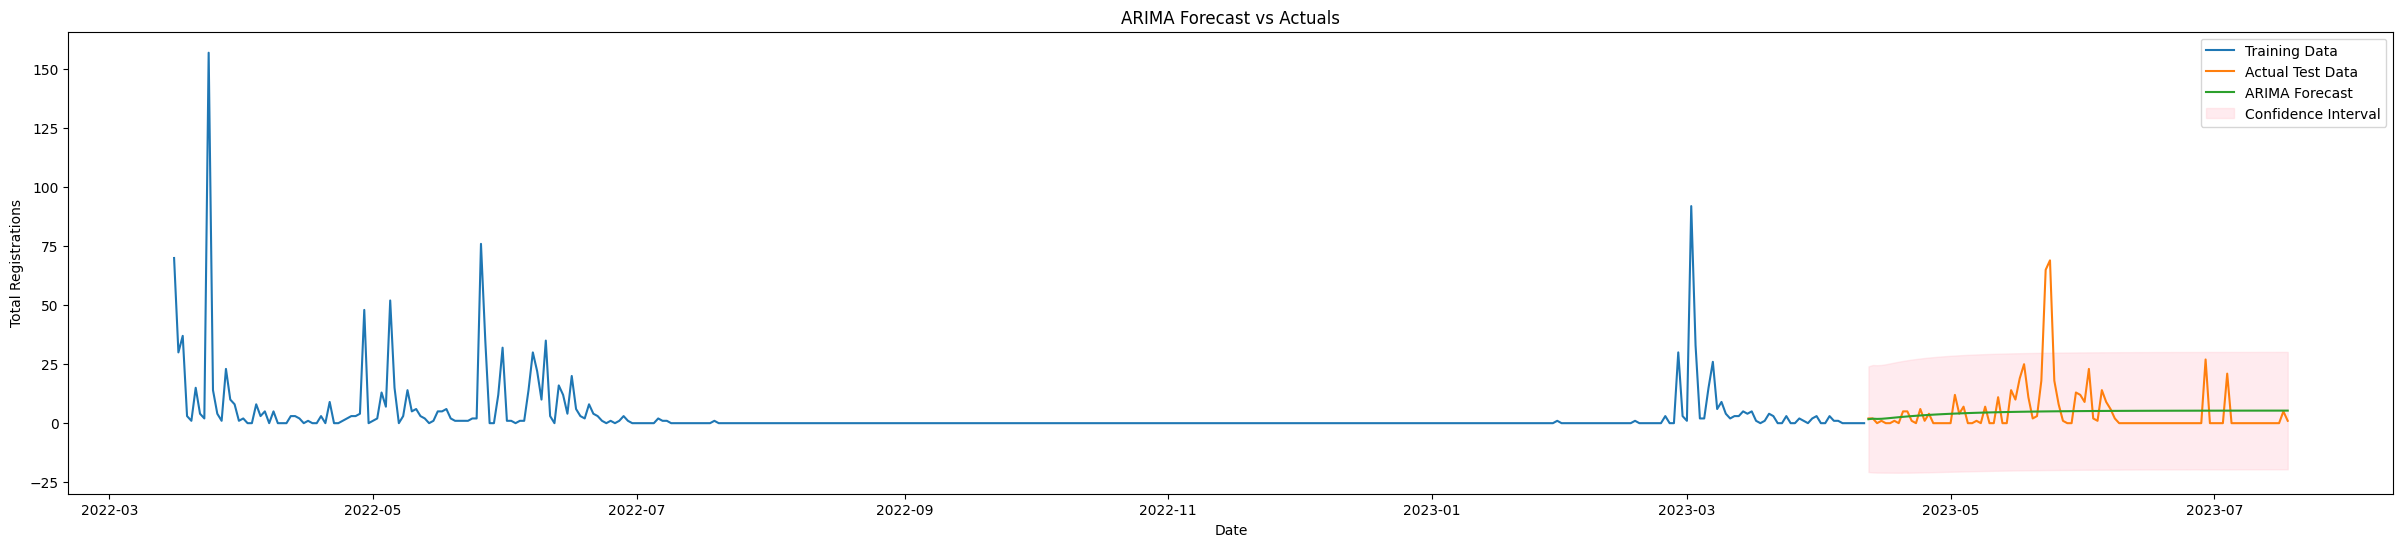

In [64]:
# Education Managers ARIMA
train, test = split_time_series_data(complete_reg_ed, split_ratio=0.8)

# For ARIMA, focusing on the endogenous variable only
train_endog_ar = train['Total Registrations']
test_endog_ar = test['Total Registrations']

# Finding the best ARIMA order
order = find_best_arima_order(train_endog_ar)

# Forecasting with ARIMA
forecast_values_arima, conf_int = arima_forecasting(train_endog_ar, order)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_ar, label='Training Data')
plt.plot(test.index, test_endog_ar, label='Actual Test Data')
plt.plot(test.index, forecast_values_arima, label='ARIMA Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


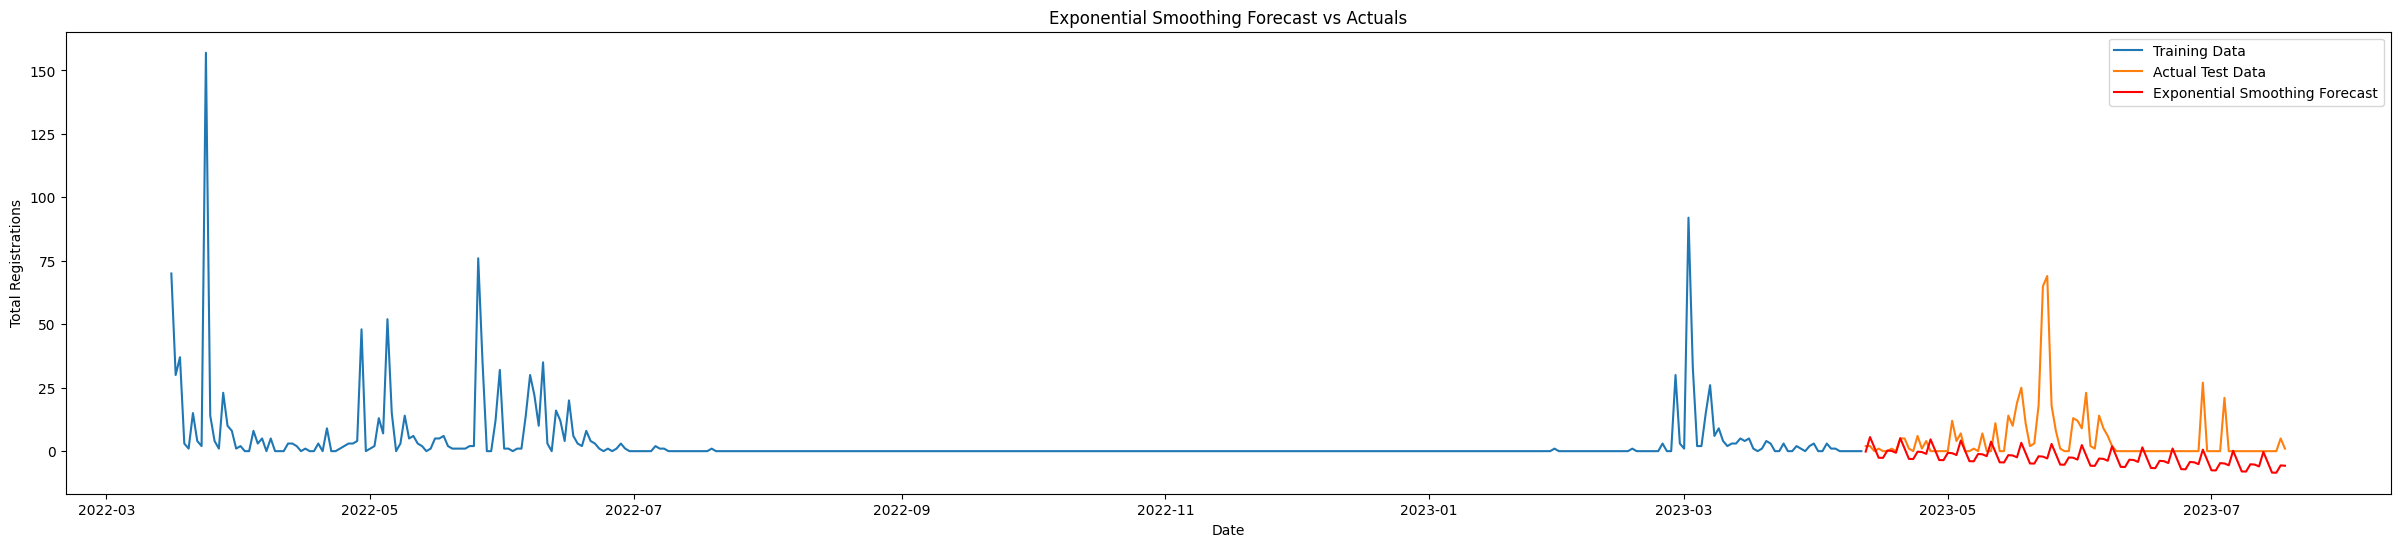

In [65]:
# Property Managers EXP
train, test = split_time_series_data(complete_reg_ed, split_ratio=0.8)

train_endog_exp= train['Total Registrations']
test_endog_exp = test['Total Registrations']

forecast_values_exp = exp_smoothing(train_endog_exp)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_exp, label='Training Data')
plt.plot(test.index, test_endog_exp, label='Actual Test Data')
plt.plot(test.index, forecast_values_exp, label='Exponential Smoothing Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.show()

In [66]:
# Calculate RMSE and MAE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_endog_ar, forecast_values_arima))
mae_arima = mean_absolute_error(test_endog_ar, forecast_values_arima)

# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

#Calculate RMSE and MAE for Exponential Smoothing
rmse_exp = np.sqrt(mean_squared_error(test_endog_exp, forecast_values_exp))
mae_exp = mean_squared_error(test_endog_exp, forecast_values_exp)

# Print the results
print(f"ARIMA RMSE (Education): {rmse_arima:.2f}, MAE: {mae_arima:.2f}")
print(f"SARIMAX RMSE (Education): {rmse_sarimax:.2f}, MAE: {mae_sarimax:.2f}")
print(f"Exponential Smoothing RMSE (Education): {rmse_exp:.2f}, MAE: {mae_exp:.2f}")

ARIMA RMSE (Education): 10.88, MAE: 6.32
SARIMAX RMSE (Education): 6.74, MAE: 4.10
Exponential Smoothing RMSE (Education): 13.18, MAE: 173.73
